# 例4.2「Jackのレンタカー会社」（図4.4）

Original Source: https://github.com/adliska/reinforcement_learning/blob/master/Chapter%2004%20Jack's%20Car%20Rental.ipynb

Jack's Car Rental is an example first introduced in Chapter 4, Example 4.2 to illustrate *policy iteration*.

Unfortunately, it's not very well described, with the most confusing part being the limit of 20 on the number of cars at each location, which doesn't seem to apply to the cars that are moved from one location to the other overnight. This means that you can start with at most 25 cars at one location at the start of the business day (in case you closed at one location with 20 cars the day before and had 5 cars moved there overnight).

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import mpl_toolkits.axes_grid1
%matplotlib inline
import itertools
import scipy.stats

## Initialization

In [2]:
# The number of cars we can keep at a single location
numcars = 20

# Maximum number of cars we can transfer from one location
# to the other overnight
maxtransfer = 5

# Discount rate
gamma = 0.9

# State value functions
V = np.zeros((numcars+1, numcars+1))
# Policy
pi = np.zeros((numcars+1, numcars+1), dtype=int)

In [3]:
def probabilities_rewards(l_req, l_ret, numcars, maxtransfer):
    # l_req: expected number of requests
    # l_ret: expected number of returns
    
    # ps[x,y]: probability of starting the day with x cars
    #          and finishing with y
    ps = np.zeros((numcars+maxtransfer+1, numcars+1))
    
    # r[x]: the expected reward from rentals when starting the day
    # with x cars
    rs = np.zeros((numcars+maxtransfer+1,))
    
    # i: the number of cars at the start of the day (this can probably 
    # be up to numcars + maxtransfer)
    for i in range(numcars+maxtransfer+1):
        # I can satisfy at most i requests
        for requests in range(i+1):
            if requests < i:
                # The probability of having i requests
                prob_requests = scipy.stats.poisson.pmf(requests, l_req)
            else:
                # For requests >= i the end result is the same (I rent out
                # i cars), therefore I sum the probabilities of having
                # i or more requests.
                prob_requests = (scipy.stats.poisson.pmf(requests, l_req) + 
                                 1 - scipy.stats.poisson.cdf(requests, l_req))
        
            # Let's update the expected reward
            rs[i] += requests * 10 * prob_requests
            
            # How many cars I can take in (until the rental place gets full)
            # This is negative in case I have more cars than I can keep.
            max_returns = numcars - i + requests
            if max_returns > 0:
                # If there is still some space for cars
                
                for returns in range(max_returns+1):
                    if returns < max_returns:
                        # The probability of having this many returns
                        prob_returns = scipy.stats.poisson.pmf(returns, l_ret)
                    else:
                        # The probability of returns >= max_returns
                        prob_returns = (scipy.stats.poisson.pmf(returns, l_ret) + 
                                        1-scipy.stats.poisson.cdf(returns, l_ret))
                    
                    # The number of cars at the end of the day (before transfers)
                    doorclosed = i - requests + returns
                    # Let's update the probability of starting the day with i cars 
                    # and finishing it with doorclosed cars.
                    ps[i, doorclosed] += prob_requests * prob_returns
            else:
                # In case I already have exactly numcars or more at the location, 
                # I will end up having the location full at the end of the day anyway,
                # irrespective of how many returned cars there will be.
                ps[i, numcars] += prob_requests * 1
                
    return ps, rs

In [4]:
# Probabilities and rewards for the first location
ps1, rs1 = probabilities_rewards(3,3, numcars, maxtransfer)
# Second location
ps2, rs2 = probabilities_rewards(4,2, numcars, maxtransfer)

## Policy Evaluation

In [5]:
def policy_evaluation(V, pi, numcars, ps1, rs1, ps2, rs2, theta):
    numiter = 0
    while True:
        numiter += 1

        delta = 0

        # Let's iterate over all states (evening, day T, before transfer)
        # i: number of cars at the first location
        # j: number of cars at the second location
        for i, j in itertools.product(range(numcars+1), range(numcars+1)):

            # Value at iteration numiter - 1
            v = V[i,j]

            # Action according to current policy (number of cars moved from
            # first location to the second location)
            action = pi[i,j]

            # Number of cars at both locations the next day (day T+1) in the
            # morning after performing action.
            nextday = (i-action, j+action)

            # Initiate the new value with:
            # (the expected reward for the transfers)
            # + (the expected reward for the rentals given the number of cars 
            #    at the start of the day T+1)
            new_value = np.abs(action)*(-2) + (rs1[nextday[0]] + rs2[nextday[1]])

            # Let's iterate over all states s' (evening, day T+1, before transfer)
            for ii, jj in itertools.product(range(numcars+1), range(numcars+1)):
                new_value += (ps1[nextday[0],ii]*ps2[nextday[1],jj] 
                              # probability of s' given s
                              * gamma * V[ii,jj])

            V[i,j] = new_value
            delta = max(delta, np.abs(v - V[i,j]))

        #print('Policy evaluation, iteration {}, delta: {}'.format(numiter, delta))
        if delta < theta:
            break
            
    return V

## Policy improvement

In [6]:
def policy_improvement(V, pi, numcars, maxtransfer, ps1, rs1, ps2, rs2, theta):
    policy_stable = True

    # Let's iterate over all states (this is in the evening, day T, before transfer)
    for i, j in itertools.product(range(numcars+1), range(numcars+1)):    
        # Action from the last iteration
        a = pi[i,j]

        # The maximum number of cars I can move from location one to two
        maxaction = min(maxtransfer, i)
        # The maximum number of cars I can move from location two to one
        minaction = -min(maxtransfer, j)

        # All possible actions
        actions = list(range(minaction, maxaction+1))

        # Let's calculate q(s,a) for all actions
        q = [0] * len(actions)
        for action_idx, action in enumerate(actions):
            # The number of cars at both locations after preforming the action
            # (this is morning, day T+1)
            nextday = (i-action, j+action)

            # Initiate the action value with the expected reward for rentals
            # given the number of cars at both locations in the morning of
            # day T+1
            q[action_idx] = rs1[nextday[0]] + rs2[nextday[1]] + np.abs(action)*(-2)

            # Let's iterate over all s' (evening, day T+1)
            for ii, jj in itertools.product(range(numcars+1), range(numcars+1)):
                q[action_idx] += (
                    ps1[nextday[0],ii]*ps2[nextday[1],jj]
                    * (gamma * V[ii,jj])
                )

        # Pick the action with the highest q(s,a)
        pi[i,j] = actions[np.argmax(q)]

        if pi[i,j] != a:
            policy_stable = False
    
    return pi, policy_stable

## Policy iteration

In [7]:
theta = 0.000001

num_policy_iterations = 4
pis = []
Vs = []

for i in range(num_policy_iterations):
    #print("POLICY ITERATION {}".format(i+1))

    V = policy_evaluation(V, pi, numcars, ps1, rs1, ps2, rs2, theta)
    pi, policy_stable = policy_improvement(V, pi, numcars, 
                                           maxtransfer, ps1, rs1, ps2, rs2, 
                                           theta)
    
    print('Policy iteration {0}: was policy stable?: {1}'.format(i, policy_stable))
    pis.append(np.copy(pi))
    Vs.append(np.copy(V))

Policy iteration 0: was policy stable?: False
Policy iteration 1: was policy stable?: False
Policy iteration 2: was policy stable?: False
Policy iteration 3: was policy stable?: False


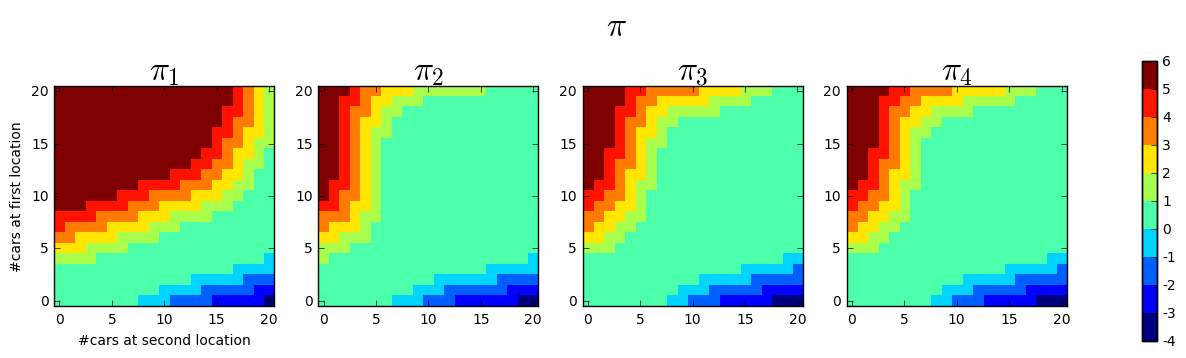

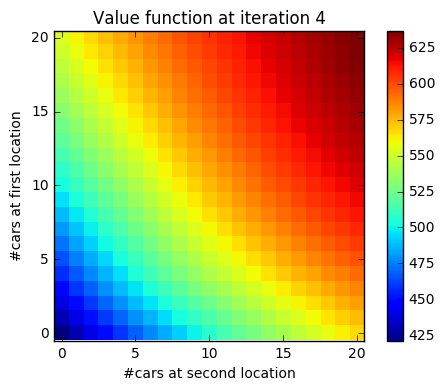

In [8]:
# Plot results

# Policies
fig1, axarr = plt.subplots(1, num_policy_iterations, figsize=(15, 4))
fig1.suptitle(r'$\pi$', fontsize=24)

cmap = plt.cm.jet
bounds = np.arange(-4,7,1)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

for i in range(num_policy_iterations):
    im = axarr[i].imshow(pis[i], interpolation="nearest", origin='lower', cmap=cmap)
    
    axarr[i].set_title("$\pi_{}$".format(i+1), fontsize=24)
    if i == 0:
        axarr[i].set_ylabel('#cars at first location')
        axarr[i].set_xlabel('#cars at second location')

fig1.subplots_adjust(right=0.8)
cbar_ax = fig1.add_axes([0.85, 0.15, 0.01, 0.7])
fig1.colorbar(im, cax=cbar_ax, cmap=cmap)
mpl.colorbar.ColorbarBase(cbar_ax, cmap=cmap, norm=norm, spacing='proportional', ticks=bounds, boundaries=bounds, format='%1i')

# Value function at the last iteration
fig2 = plt.figure()
plt.imshow(Vs[-1], interpolation="nearest", origin='lower')
plt.colorbar()
plt.title('Value function at iteration {}'.format(num_policy_iterations))
plt.ylabel('#cars at first location')
plt.xlabel('#cars at second location')